<a href="https://colab.research.google.com/github/ksulaiman1/MCS7204-Deep-Learning-Project/blob/main/chest_opacity_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, SeparableConv2D, GlobalAveragePooling2D, Input, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, layers, optimizers

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/deep_learning_project/dataset1/known_images

/content/drive/MyDrive/deep_learning_project/dataset1/known_images


In [20]:
!ls

normal	resized_unknown  sick


In [4]:
data_test = []
for img in glob.glob('resized_unknown/*.png'):
  data_test.append((img))

In [5]:
test_df = pd.DataFrame(data_test, columns=['image'],index=None)

In [ ]:
test_df

In [12]:
# unknown_data = tf.keras.preprocessing.image_dataset_from_directory(
#     "/content/drive/MyDrive/deep_learning_project/dataset1/known_images/resized_unknown", image_size = (224, 224)
# )

In [6]:
# normal = normal_dir.glob("*.png")
# sick = sick_dir.glob("*.png")
train_data = []
for img in glob.glob('normal/*.png'):
  train_data.append((img,0))

for img in glob.glob('sick/*.png'):
  train_data.append((img,1))


In [7]:
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

In [6]:
train_data.head(10)

,image,label
0,normal/normal_58.png,0
1,normal/normal_331.png,0
2,normal/normal_89.png,0
3,normal/normal_151.png,0
4,normal/normal_237.png,0
5,normal/normal_203.png,0
6,normal/normal_281.png,0
7,normal/normal_130.png,0
8,normal/normal_132.png,0
9,normal/normal_330.png,0


In [7]:
train_data.tail(10)

,image,label
705,sick/sick_297.png,1
706,sick/sick_48.png,1
707,sick/sick_247.png,1
708,sick/sick_123.png,1
709,sick/sick_324.png,1
710,sick/sick_13.png,1
711,sick/sick_330.png,1
712,sick/sick_306.png,1
713,sick/sick_77.png,1
714,sick/sick_357.png,1


In [ ]:
# path = 'Resized_Shapes'
# if not os.path.exists(path):
#     os.makedirs(path)
    
# for filename in train_data.image:
  
#   img = Image.open(filename).resize((224,224))
#   img.save('{}{}{}'.format(path,'/',os.path.split(filename)[1]))

In [ ]:
img = cv2.imread('normal/normal_107.png')

(224, 224, 3)


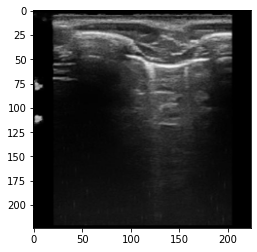

In [ ]:
print(img.shape)
# gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
# print(gray.shape)
plt.imshow(img);

In [ ]:
train_data['label'].value_counts()

0    364
1    351
Name: label, dtype: int64

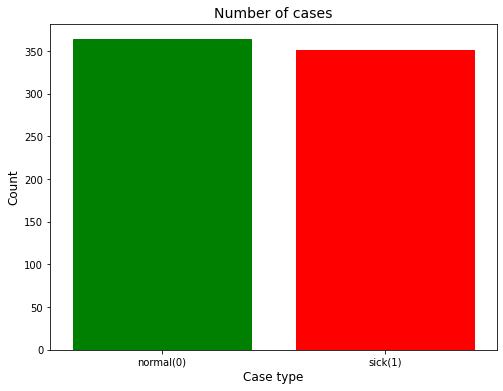

In [8]:
cases_count = train_data['label'].value_counts()
# Plot the results 
plt.figure(figsize=(8,6))
ax = sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['normal(0)', 'sick(1)'])


ax.patches[0].set_color('green')
ax.patches[1].set_color('red')


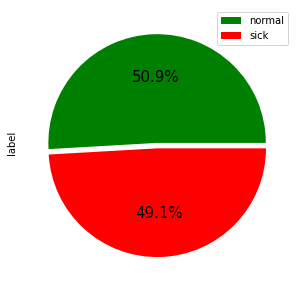

In [9]:
plt.figure(figsize=(10,5))

train_data['label'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['green','red'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['normal', 'sick'])
plt.show()

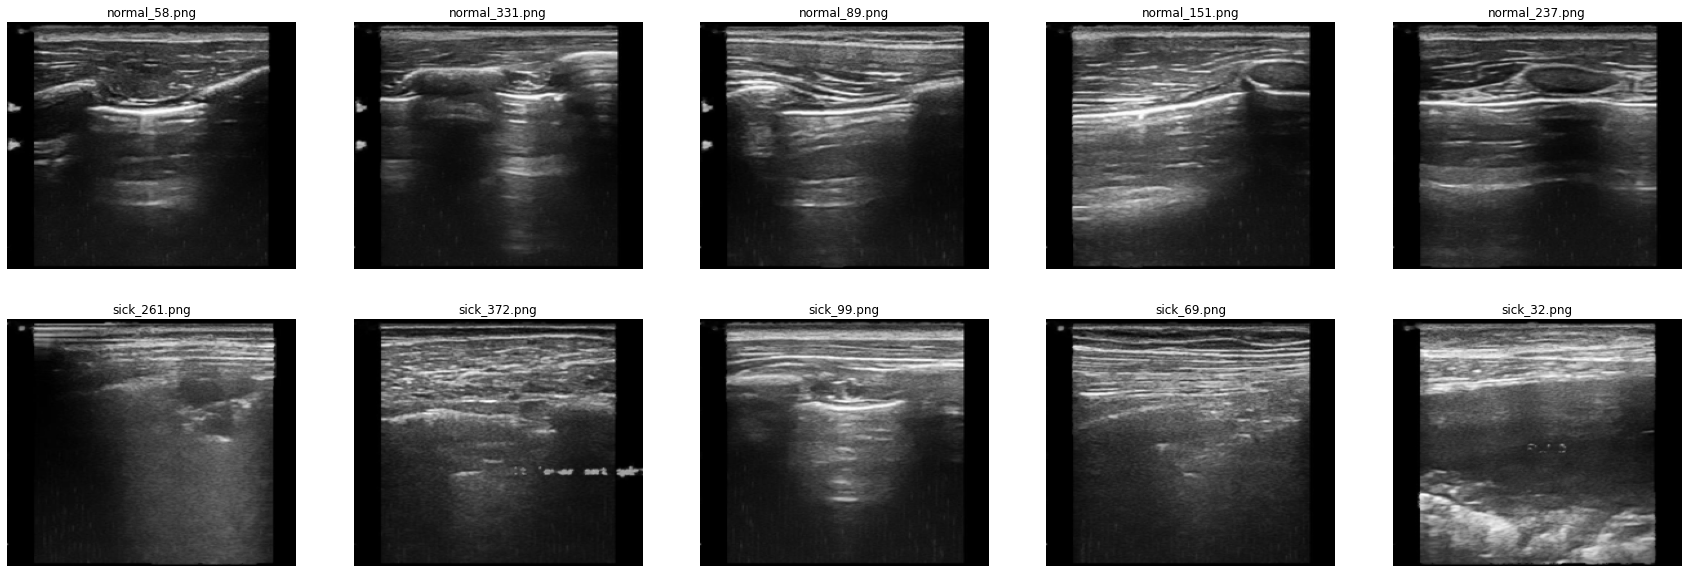

In [ ]:
sick_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = normal_samples + sick_samples
del sick_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = Image.open(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title(samples[i].split("/")[1])
    else:
        ax[i//5, i%5].set_title(samples[i].split("/")[1])
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [ ]:
train_data.dtypes

image    object
label     int64
dtype: object

In [8]:
image_dir = "/content/drive/MyDrive/deep_learning_project/dataset1/known_images"
train_data['label'] = train_data['label'].astype('str')

In [133]:
train_set, valid_set = train_test_split(train_data, test_size = 0.25, shuffle=True)
val_set, test_set  = train_test_split(valid_set, test_size = 0.15)

In [134]:
train_set.shape, val_set.shape, test_set.shape

((536, 2), (152, 2), (27, 2))

In [135]:
train_set['label'].value_counts()


0    276
1    260
Name: label, dtype: int64

In [136]:
val_set['label'].value_counts()


1    78
0    74
Name: label, dtype: int64

In [122]:
test_set['label'].value_counts()

0    28
1    15
Name: label, dtype: int64

In [10]:
image_size  = 224

In [14]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#   '/content/drive/MyDrive/deep_learning_project/dataset1/known_images',
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=1,
  
#   color_mode = 'grayscale')

# val_ds = tf.keras.utils.image_dataset_from_directory(
#   '/content/drive/MyDrive/deep_learning_project/dataset1/known_images',
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=1,
#   color_mode = 'grayscale')

# test_dataset = val_ds.take(5)
# val_ds = val_ds.skip(5)

# print('Batches for testing -->', test_dataset.cardinality())
# print('Batches for validating -->', val_ds.cardinality())

Found 715 files belonging to 2 classes.
Using 572 files for training.
Found 715 files belonging to 2 classes.
Using 143 files for validation.
Batches for testing --> tf.Tensor(5, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(138, shape=(), dtype=int64)


In [186]:
#Training  Augumentation
datagen = ImageDataGenerator(
                                rescale=1./255,
                              rotation_range=10,
                              # width_shift_range=0.10,
                              # height_shift_range=0.1,
                              # shear_range=0.1,
                            #  zoom_range = 0.1,
                              horizontal_flip=True,
                              # vertical_flip=True,
                              # fill_mode='nearest',
                             )
train_datagen = datagen.flow_from_dataframe(dataframe= train_set,
                                
                                            directory = image_dir,
                                            x_col = "image",
                                            y_col = "label",
                                            target_size = (image_size,image_size),
                                            batch_size = 13,
                                            class_mode = "binary",
                                            # color_mode='grayscale',
                                            )




Found 536 validated image filenames belonging to 2 classes.


In [187]:
validation_datagen = ImageDataGenerator(
    rescale = 1./255)
                                        

valid_datagen = validation_datagen.flow_from_dataframe(val_set,
                                            directory = image_dir,
                                            x_col = "image",
                                            y_col = "label",
                                            target_size = (image_size, image_size),
                                            class_mode = "binary",
                                            # color_mode='grayscale',
                                            batch_size=13,
                                            )

Found 152 validated image filenames belonging to 2 classes.


In [188]:
test_datagen= validation_datagen.flow_from_dataframe(
                                dataframe = test_set,
	                              directory = image_dir,
	                              x_col = "image",
                                y_col = 'label',
                                target_size = (image_size, image_size),
                                batch_size = 13,
                                class_mode = "binary",
                                # color_mode='grayscale'
                                )

# unknown_datagen = validation_datagen.flow_from_dataframe()

Found 27 validated image filenames belonging to 2 classes.


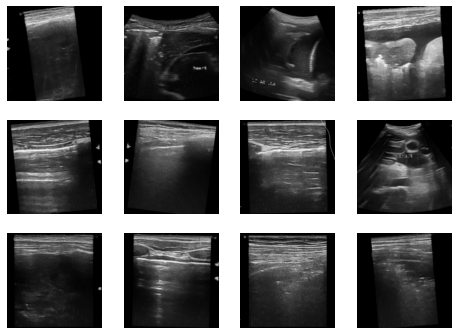

In [189]:
plt.figure(figsize=(8,8))
for i in range(1,13):
  plt.subplot(4, 4, i)
  # convert to unsigned integers for plotting
  bat = train_datagen.next()
  image = bat[0][0]#.astype('uint8')

 
  plt.imshow(image)
  # plt.gca().set_title(str(bat[1][i-1].astype('int')))
 
  plt.axis('off')

In [190]:
model = Sequential()
# model.add(ZeroPadding2D((1,1),input_shape=tr))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape = (224, 224, 3 ), 
                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.L2(1e-4),
                activity_regularizer=regularizers.L2(1e-5)))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                 bias_regularizer=regularizers.L2(1e-4),
#                 activity_regularizer=regularizers.L2(1e-5)))
model.add(MaxPool2D((2,2), strides=(2,2)))

# model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.L2(1e-4),
                activity_regularizer=regularizers.L2(1e-5)))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                 bias_regularizer=regularizers.L2(1e-4),
#                 activity_regularizer=regularizers.L2(1e-5)))
model.add(MaxPool2D((2,2), strides=(2,2)))

# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                 bias_regularizer=regularizers.L2(1e-4),
#                 activity_regularizer=regularizers.L2(1e-5)))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                 bias_regularizer=regularizers.L2(1e-4),
#                 activity_regularizer=regularizers.L2(1e-5)))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                 bias_regularizer=regularizers.L2(1e-4),
#                 activity_regularizer=regularizers.L2(1e-5)))
# model.add(MaxPool2D((2,2), strides=(2,2)))

# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                 bias_regularizer=regularizers.L2(1e-4),
#                 activity_regularizer=regularizers.L2(1e-5)))
# # model.add(ZeroPadding2D((1,1)))
# # model.add(Conv2D(512, (3, 3), activation='relu'))
# # model.add(ZeroPadding2D((1,1)))
# # model.add(Conv2D(512, (3, 3), activation='relu'))
# model.add(MaxPool2D((2,2), strides=(2,2)))

# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(512, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(512, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(512, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(16, activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.L2(1e-4),
                activity_regularizer=regularizers.L2(1e-5))
                )
model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                 bias_regularizer=regularizers.L2(1e-4),
#                 activity_regularizer=regularizers.L2(1e-5)))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [191]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 flatten_29 (Flatten)        (None, 100352)            0         
                                                                 
 dense_65 (Dense)            (None, 16)              

In [193]:
filepath = "opacity_model.h5"
    
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.2, min_delta=1e-7),
             EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-7),
             ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)
             ]
model.compile(loss='binary_crossentropy'
              , optimizer = optimizers.Adam(learning_rate=1e-4), metrics='binary_accuracy')

In [194]:
history = model.fit(train_datagen, epochs = 100, validation_data = valid_datagen)


Epoch 1/100
42/42 [==============================] - 8s 177ms/step - loss: 0.7897 - binary_accuracy: 0.6716 - val_loss: 0.6392 - val_binary_accuracy: 0.8026
Epoch 2/100
42/42 [==============================] - 7s 173ms/step - loss: 0.5832 - binary_accuracy: 0.8265 - val_loss: 0.4536 - val_binary_accuracy: 0.9079
Epoch 3/100
42/42 [==============================] - 9s 202ms/step - loss: 0.4818 - binary_accuracy: 0.8638 - val_loss: 0.3886 - val_binary_accuracy: 0.9013
Epoch 4/100
42/42 [==============================] - 7s 173ms/step - loss: 0.4478 - binary_accuracy: 0.8545 - val_loss: 0.3946 - val_binary_accuracy: 0.9145
Epoch 5/100
42/42 [==============================] - 7s 171ms/step - loss: 0.4142 - binary_accuracy: 0.8843 - val_loss: 0.3433 - val_binary_accuracy: 0.9145
Epoch 6/100
42/42 [==============================] - 7s 172ms/step - loss: 0.3896 - binary_accuracy: 0.8731 - val_loss: 0.3221 - val_binary_accuracy: 0.9145
Epoch 7/100
42/42 [==============================] - 7s 17

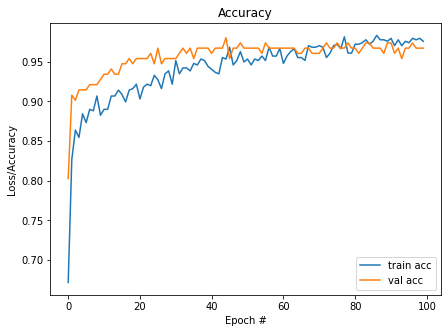

In [195]:
# plt.style.use("ggplot")
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, 100), history.history["binary_accuracy"], label="train acc")
plt.plot(np.arange(0, 100), history.history["val_binary_accuracy"], label="val acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

plt.show()

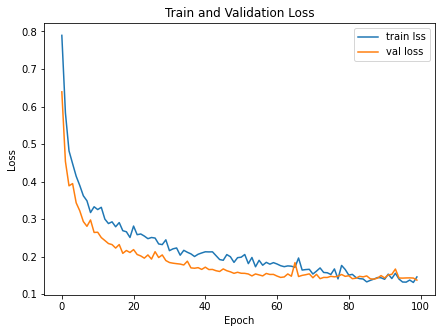

In [196]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, 100), history.history["loss"], label="train lss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val loss")
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
# plt.style.use("ggplot")
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, 100), history.history["binary_accuracy"], label="train acc")
plt.plot(np.arange(0, 100), history.history["val_binary_accuracy"], label="val acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

plt.show()

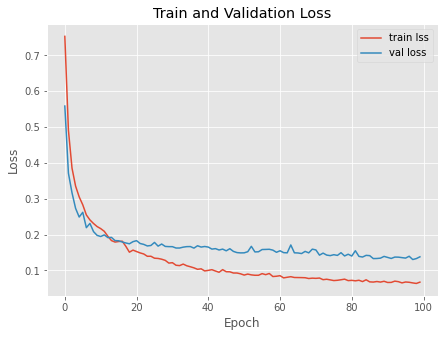

In [126]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, 100), history.history["loss"], label="train lss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val loss")
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [127]:
prediction = model.predict(test_datagen)

In [144]:
prediction

array([[4.0858339e-07],
       [1.8528169e-03],
       [1.4709095e-03],
       [5.1303854e-04],
       [9.9989271e-01],
       [3.3751572e-03],
       [9.9994302e-01],
       [1.3247102e-04],
       [3.7349860e-06],
       [9.9637480e-03],
       [4.6453262e-03],
       [2.2284504e-02],
       [7.7518675e-04],
       [9.9421257e-01],
       [9.9924123e-01]], dtype=float32)

In [132]:
test_acc = model.evaluate(test_datagen)

2/2 [==============================] - 0s 15ms/step - loss: 0.3128 - binary_accuracy: 0.9333


In [138]:
test_acc

[0.3127981722354889, 0.9333333373069763]

In [159]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score

In [135]:
test_datagen.classes

[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]

In [146]:
np.argmax(prediction, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [149]:
print(classification_report(test_datagen.classes, np.argmax(prediction, axis=1), zero_division=True))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.00      0.00         5

    accuracy                           0.67        15
   macro avg       0.83      0.50      0.40        15
weighted avg       0.78      0.67      0.53        15



In [151]:
cm = confusion_matrix(test_datagen.classes, np.argmax(prediction, axis=1))

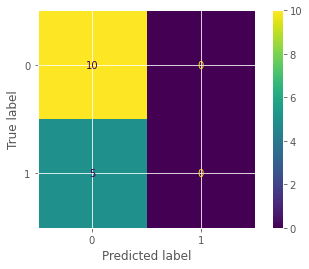

In [158]:
ConfusionMatrixDisplay(cm).plot()
# plt.grid()

In [ ]:
unknown_image = '/content/drive/MyDrive/deep_learning_project/dataset1/unknown_images'